In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession

In [2]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

spark=SparkSession.builder.master ("local[*]").appName("part4").getOrCreate()

In [3]:
spark=SparkSession.builder.appName('Prediction_model').getOrCreate()

#create spark dataframe of input csv file
df=spark.read.csv('C:\\Users\\DELL\\OneDrive\\Desktop\\Data Science\\Hadoop\\Spark\\Project\\application_train.csv',inferSchema=True,header=True)
df.show(10)

+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+--------------+---------------+----------------+----------+---------------+--------------------+---------------------------+--------------------------+--------------------------+--------------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+----------------+
|TARGET|NAME_CONTRACT_TYPE|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|AMT_CREDIT|AMT_ANNUITY|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_EMP_PHONE|FLAG_WORK_PHONE|FLAG_CONT_MOBILE|FLAG_PHONE|CNT_FAM_MEMBERS|REGION_RATING_CLIENT|REGION_RATING_CLIENT_W_CITY|REG_REGION_NOT_LIVE_R

In [4]:
df.printSchema()

root
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- FLAG_MOBIL: integer (nullable = true)
 |-- FLAG_EMP_PHONE: integer (nullable = true)
 |-- FLAG_WORK_PHONE: integer (nullable = true)
 |-- FLAG_CONT_MOBILE: integer (nullable = true)
 |-- FLAG_PHONE: integer (nullable = true)
 |-- CNT_FAM_MEMBERS: integer (nullable = true)
 |-- REGION_RATING_CLIENT: in

In [5]:
df.head(5)

[Row(TARGET=1, NAME_CONTRACT_TYPE='Cash loans', CODE_GENDER='M', FLAG_OWN_CAR='N', FLAG_OWN_REALTY='Y', CNT_CHILDREN=0, AMT_INCOME_TOTAL=202500.0, AMT_CREDIT=406597.5, AMT_ANNUITY=24700.5, NAME_INCOME_TYPE='Working', NAME_EDUCATION_TYPE='Secondary / secondary special', NAME_FAMILY_STATUS='Single / not married', NAME_HOUSING_TYPE='House / apartment', DAYS_BIRTH=-9461, DAYS_EMPLOYED=-637, FLAG_MOBIL=1, FLAG_EMP_PHONE=1, FLAG_WORK_PHONE=0, FLAG_CONT_MOBILE=1, FLAG_PHONE=1, CNT_FAM_MEMBERS=1, REGION_RATING_CLIENT=2, REGION_RATING_CLIENT_W_CITY=2, REG_REGION_NOT_LIVE_REGION=0, REG_REGION_NOT_WORK_REGION=0, ORGANIZATION_TYPE='Business Entity Type 3', FLAG_DOCUMENT_2=0, FLAG_DOCUMENT_3=1, FLAG_DOCUMENT_4=0, FLAG_DOCUMENT_5=0, FLAG_DOCUMENT_6=0, FLAG_DOCUMENT_7=0, FLAG_DOCUMENT_8=0, FLAG_DOCUMENT_9=0, FLAG_DOCUMENT_10=0, FLAG_DOCUMENT_11=0, FLAG_DOCUMENT_12=0),
 Row(TARGET=0, NAME_CONTRACT_TYPE='Cash loans', CODE_GENDER='F', FLAG_OWN_CAR='N', FLAG_OWN_REALTY='N', CNT_CHILDREN=0, AMT_INCOME_TOT

In [6]:
df.count()

307511

In [7]:
for col in df.columns:
    print(col,"\t", "with null values:" , df.filter(df[col].isNull()).count())

TARGET 	 with null values: 0
NAME_CONTRACT_TYPE 	 with null values: 0
CODE_GENDER 	 with null values: 0
FLAG_OWN_CAR 	 with null values: 0
FLAG_OWN_REALTY 	 with null values: 0
CNT_CHILDREN 	 with null values: 0
AMT_INCOME_TOTAL 	 with null values: 0
AMT_CREDIT 	 with null values: 0
AMT_ANNUITY 	 with null values: 12
NAME_INCOME_TYPE 	 with null values: 0
NAME_EDUCATION_TYPE 	 with null values: 0
NAME_FAMILY_STATUS 	 with null values: 0
NAME_HOUSING_TYPE 	 with null values: 0
DAYS_BIRTH 	 with null values: 0
DAYS_EMPLOYED 	 with null values: 0
FLAG_MOBIL 	 with null values: 0
FLAG_EMP_PHONE 	 with null values: 0
FLAG_WORK_PHONE 	 with null values: 0
FLAG_CONT_MOBILE 	 with null values: 0
FLAG_PHONE 	 with null values: 0
CNT_FAM_MEMBERS 	 with null values: 2
REGION_RATING_CLIENT 	 with null values: 0
REGION_RATING_CLIENT_W_CITY 	 with null values: 0
REG_REGION_NOT_LIVE_REGION 	 with null values: 0
REG_REGION_NOT_WORK_REGION 	 with null values: 0
ORGANIZATION_TYPE 	 with null values: 0
F

In [8]:
df = df.fillna({'AMT_ANNUITY':4})

In [9]:
df=df.fillna({'CNT_FAM_MEMBERS':0})

In [10]:
df.toPandas().isnull().sum()

TARGET                         0
NAME_CONTRACT_TYPE             0
CODE_GENDER                    0
FLAG_OWN_CAR                   0
FLAG_OWN_REALTY                0
CNT_CHILDREN                   0
AMT_INCOME_TOTAL               0
AMT_CREDIT                     0
AMT_ANNUITY                    0
NAME_INCOME_TYPE               0
NAME_EDUCATION_TYPE            0
NAME_FAMILY_STATUS             0
NAME_HOUSING_TYPE              0
DAYS_BIRTH                     0
DAYS_EMPLOYED                  0
FLAG_MOBIL                     0
FLAG_EMP_PHONE                 0
FLAG_WORK_PHONE                0
FLAG_CONT_MOBILE               0
FLAG_PHONE                     0
CNT_FAM_MEMBERS                0
REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
REG_REGION_NOT_LIVE_REGION     0
REG_REGION_NOT_WORK_REGION     0
ORGANIZATION_TYPE              0
FLAG_DOCUMENT_2                0
FLAG_DOCUMENT_3                0
FLAG_DOCUMENT_4                0
FLAG_DOCUMENT_5                0
FLAG_DOCUM

In [11]:
df.describe(["AMT_INCOME_TOTAL"]).show()

+-------+------------------+
|summary|  AMT_INCOME_TOTAL|
+-------+------------------+
|  count|            307511|
|   mean| 168797.9192969845|
| stddev|237123.14627885542|
|    min|           25650.0|
|    max|            1.17E8|
+-------+------------------+



In [ ]:
from matplotlib import cm
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Distribution of Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(df.toPandas().describe().columns, range(2,36)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(df.toPandas()[col])
    plt.style.use('dark_background') 
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

In [12]:
df.toPandas()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,Working,...,1,0,0,0,0,0,0,0,0,0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,State servant,...,1,0,0,0,0,0,0,0,0,0
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,Working,...,0,0,0,0,0,0,0,0,0,0
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,Working,...,1,0,0,0,0,0,0,0,0,0
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,Working,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,Working,...,0,0,0,0,0,1,0,0,0,0
307507,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,Pensioner,...,1,0,0,0,0,0,0,0,0,0
307508,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,Working,...,1,0,0,0,0,0,0,0,0,0
307509,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,Commercial associate,...,1,0,0,0,0,0,0,0,0,0


In [13]:
df.columns

['TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'ORGANIZATION_TYPE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12']

In [14]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer)

assembler = VectorAssembler(inputCols=['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY'],outputCol='features')

In [15]:
output = assembler.transform(df)

In [16]:
output.select("features").show()

+--------------------+
|            features|
+--------------------+
|[202500.0,406597....|
|[270000.0,1293502...|
|[67500.0,135000.0...|
|[135000.0,312682....|
|[121500.0,513000....|
|[99000.0,490495.5...|
|[171000.0,1560726...|
|[360000.0,1530000...|
|[112500.0,1019610...|
|[135000.0,405000....|
|[112500.0,652500....|
|[38419.155,148365...|
|[67500.0,80865.0,...|
|[225000.0,918468....|
|[189000.0,773680....|
|[157500.0,299772....|
|[108000.0,509602....|
|[81000.0,270000.0...|
|[112500.0,157500....|
|[90000.0,544491.0...|
+--------------------+
only showing top 20 rows



In [17]:
final_data = output.select("features",'TARGET')

In [18]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='features',labelCol='TARGET')
train, test = final_data.randomSplit([0.7,.3])

In [19]:
trained_model = lr.fit(train)
unlabeled_data=test.select('features')
unlabeled_data.show(5)


+--------------------+
|            features|
+--------------------+
|[27000.0,71955.0,...|
|[27000.0,112500.0...|
|[29250.0,135000.0...|
|[29250.0,152820.0...|
|[29250.0,225000.0...|
+--------------------+
only showing top 5 rows



In [20]:
predictions=trained_model.transform(test)
predictions.show()

+--------------------+------+--------------------+--------------------+----------+
|            features|TARGET|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+----------+
|[27000.0,71955.0,...|     0|[2.30739299642364...|[0.90948747572302...|       0.0|
|[27000.0,112500.0...|     0|[2.34157381418959...|[0.91226213490968...|       0.0|
|[29250.0,135000.0...|     0|[2.34380869343335...|[0.91244084975824...|       0.0|
|[29250.0,152820.0...|     0|[2.32952638699287...|[0.91129305826454...|       0.0|
|[29250.0,225000.0...|     0|[2.31178899374845...|[0.90984870342474...|       0.0|
|[31500.0,142200.0...|     0|[2.32887243194361...|[0.91124017961230...|       0.0|
|[31500.0,314055.0...|     0|[2.38993603602135...|[0.91605664960395...|       0.0|
|[31500.0,585000.0...|     1|[2.43612742572884...|[0.91954103929629...|       0.0|
|[31500.0,634482.0...|     0|[2.52275927680052...|[0.92572200785143...|       0.0|
|[31

In [22]:
accuracy = predictions.filter(test.TARGET == predictions.prediction).count() / float(test.count())
print("Accuracy : ",accuracy)

Accuracy :  0.9193044689394022


In [23]:
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[    0  7416]
 [    0 84485]]


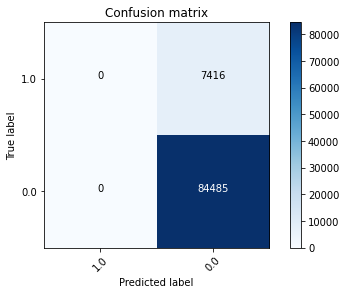

In [24]:
y_true = predictions.select("TARGET")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [31]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
data = sc.parallelize([1, 2, 4 , 5 , 6 , 7 , 8], 3) 
def function(iterator): 
    yield sum([_ for _ in iterator]) 
data.mapPartitions(function).collect()


[3, 9, 21]

In [32]:
 data.getStorageLevel()

StorageLevel(False, False, False, False, 1)

In [33]:
sc = SparkContext("local", "serialization app", serializer = MarshalSerializer()) 
print(sc.parallelize(list(range(1000))).map(lambda x: str(x*3)*x).take(5))

NameError: name 'MarshalSerializer' is not defined

In [39]:
num = sc.accumulator(10) 
def f(x): 
    global num 
    num+=x 
    rdd = sc.parallelize([20,30,40,50]) 
    rdd.foreach(f) 
    final = num.value
final

10

In [40]:
rdd1 = sc.parallelize((0,23), 6) 
rdd2 = rdd1.repartition(4) 
print(rdd2.collect())

[0, 23]


In [41]:
schema = StructType([ StructField('firstname', StringType(), True), StructField('middlename', StringType(), True), StructField('lastname', StringType(), True) ])

In [42]:
schema

StructType(List(StructField(firstname,StringType,true),StructField(middlename,StringType,true),StructField(lastname,StringType,true)))

In [43]:
df.select(["firstname","lastname"])

AnalysisException: cannot resolve '`firstname`' given input columns: [AMT_ANNUITY, AMT_CREDIT, AMT_INCOME_TOTAL, CNT_CHILDREN, CNT_FAM_MEMBERS, CODE_GENDER, DAYS_BIRTH, DAYS_EMPLOYED, FLAG_CONT_MOBILE, FLAG_DOCUMENT_10, FLAG_DOCUMENT_11, FLAG_DOCUMENT_12, FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, FLAG_DOCUMENT_6, FLAG_DOCUMENT_7, FLAG_DOCUMENT_8, FLAG_DOCUMENT_9, FLAG_EMP_PHONE, FLAG_MOBIL, FLAG_OWN_CAR, FLAG_OWN_REALTY, FLAG_PHONE, FLAG_WORK_PHONE, NAME_CONTRACT_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, NAME_INCOME_TYPE, ORGANIZATION_TYPE, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, TARGET];
'Project ['firstname, 'lastname]
+- Project [TARGET#16, NAME_CONTRACT_TYPE#17, CODE_GENDER#18, FLAG_OWN_CAR#19, FLAG_OWN_REALTY#20, CNT_CHILDREN#21, AMT_INCOME_TOTAL#22, AMT_CREDIT#23, AMT_ANNUITY#1983, NAME_INCOME_TYPE#25, NAME_EDUCATION_TYPE#26, NAME_FAMILY_STATUS#27, NAME_HOUSING_TYPE#28, DAYS_BIRTH#29, DAYS_EMPLOYED#30, FLAG_MOBIL#31, FLAG_EMP_PHONE#32, FLAG_WORK_PHONE#33, FLAG_CONT_MOBILE#34, FLAG_PHONE#35, coalesce(CNT_FAM_MEMBERS#36, cast(0 as int)) AS CNT_FAM_MEMBERS#2058, REGION_RATING_CLIENT#37, REGION_RATING_CLIENT_W_CITY#38, REG_REGION_NOT_LIVE_REGION#39, ... 13 more fields]
   +- Project [TARGET#16, NAME_CONTRACT_TYPE#17, CODE_GENDER#18, FLAG_OWN_CAR#19, FLAG_OWN_REALTY#20, CNT_CHILDREN#21, AMT_INCOME_TOTAL#22, AMT_CREDIT#23, coalesce(nanvl(AMT_ANNUITY#24, cast(null as double)), cast(4 as double)) AS AMT_ANNUITY#1983, NAME_INCOME_TYPE#25, NAME_EDUCATION_TYPE#26, NAME_FAMILY_STATUS#27, NAME_HOUSING_TYPE#28, DAYS_BIRTH#29, DAYS_EMPLOYED#30, FLAG_MOBIL#31, FLAG_EMP_PHONE#32, FLAG_WORK_PHONE#33, FLAG_CONT_MOBILE#34, FLAG_PHONE#35, CNT_FAM_MEMBERS#36, REGION_RATING_CLIENT#37, REGION_RATING_CLIENT_W_CITY#38, REG_REGION_NOT_LIVE_REGION#39, ... 13 more fields]
      +- Relation[TARGET#16,NAME_CONTRACT_TYPE#17,CODE_GENDER#18,FLAG_OWN_CAR#19,FLAG_OWN_REALTY#20,CNT_CHILDREN#21,AMT_INCOME_TOTAL#22,AMT_CREDIT#23,AMT_ANNUITY#24,NAME_INCOME_TYPE#25,NAME_EDUCATION_TYPE#26,NAME_FAMILY_STATUS#27,NAME_HOUSING_TYPE#28,DAYS_BIRTH#29,DAYS_EMPLOYED#30,FLAG_MOBIL#31,FLAG_EMP_PHONE#32,FLAG_WORK_PHONE#33,FLAG_CONT_MOBILE#34,FLAG_PHONE#35,CNT_FAM_MEMBERS#36,REGION_RATING_CLIENT#37,REGION_RATING_CLIENT_W_CITY#38,REG_REGION_NOT_LIVE_REGION#39,... 13 more fields] csv


In [45]:
from pyspark.sql.functions import col 
df.select(col("firstname"),col("lastname"))

AnalysisException: cannot resolve '`firstname`' given input columns: [AMT_ANNUITY, AMT_CREDIT, AMT_INCOME_TOTAL, CNT_CHILDREN, CNT_FAM_MEMBERS, CODE_GENDER, DAYS_BIRTH, DAYS_EMPLOYED, FLAG_CONT_MOBILE, FLAG_DOCUMENT_10, FLAG_DOCUMENT_11, FLAG_DOCUMENT_12, FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, FLAG_DOCUMENT_6, FLAG_DOCUMENT_7, FLAG_DOCUMENT_8, FLAG_DOCUMENT_9, FLAG_EMP_PHONE, FLAG_MOBIL, FLAG_OWN_CAR, FLAG_OWN_REALTY, FLAG_PHONE, FLAG_WORK_PHONE, NAME_CONTRACT_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, NAME_INCOME_TYPE, ORGANIZATION_TYPE, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, TARGET];
'Project ['firstname, 'lastname]
+- Project [TARGET#16, NAME_CONTRACT_TYPE#17, CODE_GENDER#18, FLAG_OWN_CAR#19, FLAG_OWN_REALTY#20, CNT_CHILDREN#21, AMT_INCOME_TOTAL#22, AMT_CREDIT#23, AMT_ANNUITY#1983, NAME_INCOME_TYPE#25, NAME_EDUCATION_TYPE#26, NAME_FAMILY_STATUS#27, NAME_HOUSING_TYPE#28, DAYS_BIRTH#29, DAYS_EMPLOYED#30, FLAG_MOBIL#31, FLAG_EMP_PHONE#32, FLAG_WORK_PHONE#33, FLAG_CONT_MOBILE#34, FLAG_PHONE#35, coalesce(CNT_FAM_MEMBERS#36, cast(0 as int)) AS CNT_FAM_MEMBERS#2058, REGION_RATING_CLIENT#37, REGION_RATING_CLIENT_W_CITY#38, REG_REGION_NOT_LIVE_REGION#39, ... 13 more fields]
   +- Project [TARGET#16, NAME_CONTRACT_TYPE#17, CODE_GENDER#18, FLAG_OWN_CAR#19, FLAG_OWN_REALTY#20, CNT_CHILDREN#21, AMT_INCOME_TOTAL#22, AMT_CREDIT#23, coalesce(nanvl(AMT_ANNUITY#24, cast(null as double)), cast(4 as double)) AS AMT_ANNUITY#1983, NAME_INCOME_TYPE#25, NAME_EDUCATION_TYPE#26, NAME_FAMILY_STATUS#27, NAME_HOUSING_TYPE#28, DAYS_BIRTH#29, DAYS_EMPLOYED#30, FLAG_MOBIL#31, FLAG_EMP_PHONE#32, FLAG_WORK_PHONE#33, FLAG_CONT_MOBILE#34, FLAG_PHONE#35, CNT_FAM_MEMBERS#36, REGION_RATING_CLIENT#37, REGION_RATING_CLIENT_W_CITY#38, REG_REGION_NOT_LIVE_REGION#39, ... 13 more fields]
      +- Relation[TARGET#16,NAME_CONTRACT_TYPE#17,CODE_GENDER#18,FLAG_OWN_CAR#19,FLAG_OWN_REALTY#20,CNT_CHILDREN#21,AMT_INCOME_TOTAL#22,AMT_CREDIT#23,AMT_ANNUITY#24,NAME_INCOME_TYPE#25,NAME_EDUCATION_TYPE#26,NAME_FAMILY_STATUS#27,NAME_HOUSING_TYPE#28,DAYS_BIRTH#29,DAYS_EMPLOYED#30,FLAG_MOBIL#31,FLAG_EMP_PHONE#32,FLAG_WORK_PHONE#33,FLAG_CONT_MOBILE#34,FLAG_PHONE#35,CNT_FAM_MEMBERS#36,REGION_RATING_CLIENT#37,REGION_RATING_CLIENT_W_CITY#38,REG_REGION_NOT_LIVE_REGION#39,... 13 more fields] csv


In [46]:
df.select("firstname","lastname")

AnalysisException: cannot resolve '`firstname`' given input columns: [AMT_ANNUITY, AMT_CREDIT, AMT_INCOME_TOTAL, CNT_CHILDREN, CNT_FAM_MEMBERS, CODE_GENDER, DAYS_BIRTH, DAYS_EMPLOYED, FLAG_CONT_MOBILE, FLAG_DOCUMENT_10, FLAG_DOCUMENT_11, FLAG_DOCUMENT_12, FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, FLAG_DOCUMENT_6, FLAG_DOCUMENT_7, FLAG_DOCUMENT_8, FLAG_DOCUMENT_9, FLAG_EMP_PHONE, FLAG_MOBIL, FLAG_OWN_CAR, FLAG_OWN_REALTY, FLAG_PHONE, FLAG_WORK_PHONE, NAME_CONTRACT_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, NAME_INCOME_TYPE, ORGANIZATION_TYPE, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, TARGET];
'Project ['firstname, 'lastname]
+- Project [TARGET#16, NAME_CONTRACT_TYPE#17, CODE_GENDER#18, FLAG_OWN_CAR#19, FLAG_OWN_REALTY#20, CNT_CHILDREN#21, AMT_INCOME_TOTAL#22, AMT_CREDIT#23, AMT_ANNUITY#1983, NAME_INCOME_TYPE#25, NAME_EDUCATION_TYPE#26, NAME_FAMILY_STATUS#27, NAME_HOUSING_TYPE#28, DAYS_BIRTH#29, DAYS_EMPLOYED#30, FLAG_MOBIL#31, FLAG_EMP_PHONE#32, FLAG_WORK_PHONE#33, FLAG_CONT_MOBILE#34, FLAG_PHONE#35, coalesce(CNT_FAM_MEMBERS#36, cast(0 as int)) AS CNT_FAM_MEMBERS#2058, REGION_RATING_CLIENT#37, REGION_RATING_CLIENT_W_CITY#38, REG_REGION_NOT_LIVE_REGION#39, ... 13 more fields]
   +- Project [TARGET#16, NAME_CONTRACT_TYPE#17, CODE_GENDER#18, FLAG_OWN_CAR#19, FLAG_OWN_REALTY#20, CNT_CHILDREN#21, AMT_INCOME_TOTAL#22, AMT_CREDIT#23, coalesce(nanvl(AMT_ANNUITY#24, cast(null as double)), cast(4 as double)) AS AMT_ANNUITY#1983, NAME_INCOME_TYPE#25, NAME_EDUCATION_TYPE#26, NAME_FAMILY_STATUS#27, NAME_HOUSING_TYPE#28, DAYS_BIRTH#29, DAYS_EMPLOYED#30, FLAG_MOBIL#31, FLAG_EMP_PHONE#32, FLAG_WORK_PHONE#33, FLAG_CONT_MOBILE#34, FLAG_PHONE#35, CNT_FAM_MEMBERS#36, REGION_RATING_CLIENT#37, REGION_RATING_CLIENT_W_CITY#38, REG_REGION_NOT_LIVE_REGION#39, ... 13 more fields]
      +- Relation[TARGET#16,NAME_CONTRACT_TYPE#17,CODE_GENDER#18,FLAG_OWN_CAR#19,FLAG_OWN_REALTY#20,CNT_CHILDREN#21,AMT_INCOME_TOTAL#22,AMT_CREDIT#23,AMT_ANNUITY#24,NAME_INCOME_TYPE#25,NAME_EDUCATION_TYPE#26,NAME_FAMILY_STATUS#27,NAME_HOUSING_TYPE#28,DAYS_BIRTH#29,DAYS_EMPLOYED#30,FLAG_MOBIL#31,FLAG_EMP_PHONE#32,FLAG_WORK_PHONE#33,FLAG_CONT_MOBILE#34,FLAG_PHONE#35,CNT_FAM_MEMBERS#36,REGION_RATING_CLIENT#37,REGION_RATING_CLIENT_W_CITY#38,REG_REGION_NOT_LIVE_REGION#39,... 13 more fields] csv


In [47]:
df.select(df.firstname,df.lastname)

AttributeError: 'DataFrame' object has no attribute 'firstname'

In [48]:
df.createOrReplaceTempView("EMP") 
spark.sql("select employee_name,department,state,salary,age,bonus from EMP ORDER BY department asc").show(truncate=False)

AnalysisException: cannot resolve '`employee_name`' given input columns: [emp.AMT_ANNUITY, emp.AMT_CREDIT, emp.AMT_INCOME_TOTAL, emp.CNT_CHILDREN, emp.CNT_FAM_MEMBERS, emp.CODE_GENDER, emp.DAYS_BIRTH, emp.DAYS_EMPLOYED, emp.FLAG_CONT_MOBILE, emp.FLAG_DOCUMENT_10, emp.FLAG_DOCUMENT_11, emp.FLAG_DOCUMENT_12, emp.FLAG_DOCUMENT_2, emp.FLAG_DOCUMENT_3, emp.FLAG_DOCUMENT_4, emp.FLAG_DOCUMENT_5, emp.FLAG_DOCUMENT_6, emp.FLAG_DOCUMENT_7, emp.FLAG_DOCUMENT_8, emp.FLAG_DOCUMENT_9, emp.FLAG_EMP_PHONE, emp.FLAG_MOBIL, emp.FLAG_OWN_CAR, emp.FLAG_OWN_REALTY, emp.FLAG_PHONE, emp.FLAG_WORK_PHONE, emp.NAME_CONTRACT_TYPE, emp.NAME_EDUCATION_TYPE, emp.NAME_FAMILY_STATUS, emp.NAME_HOUSING_TYPE, emp.NAME_INCOME_TYPE, emp.ORGANIZATION_TYPE, emp.REGION_RATING_CLIENT, emp.REGION_RATING_CLIENT_W_CITY, emp.REG_REGION_NOT_LIVE_REGION, emp.REG_REGION_NOT_WORK_REGION, emp.TARGET]; line 1 pos 7;
'Sort ['department ASC NULLS FIRST], true
+- 'Project ['employee_name, 'department, 'state, 'salary, 'age, 'bonus]
   +- SubqueryAlias emp
      +- Project [TARGET#16, NAME_CONTRACT_TYPE#17, CODE_GENDER#18, FLAG_OWN_CAR#19, FLAG_OWN_REALTY#20, CNT_CHILDREN#21, AMT_INCOME_TOTAL#22, AMT_CREDIT#23, AMT_ANNUITY#1983, NAME_INCOME_TYPE#25, NAME_EDUCATION_TYPE#26, NAME_FAMILY_STATUS#27, NAME_HOUSING_TYPE#28, DAYS_BIRTH#29, DAYS_EMPLOYED#30, FLAG_MOBIL#31, FLAG_EMP_PHONE#32, FLAG_WORK_PHONE#33, FLAG_CONT_MOBILE#34, FLAG_PHONE#35, coalesce(CNT_FAM_MEMBERS#36, cast(0 as int)) AS CNT_FAM_MEMBERS#2058, REGION_RATING_CLIENT#37, REGION_RATING_CLIENT_W_CITY#38, REG_REGION_NOT_LIVE_REGION#39, ... 13 more fields]
         +- Project [TARGET#16, NAME_CONTRACT_TYPE#17, CODE_GENDER#18, FLAG_OWN_CAR#19, FLAG_OWN_REALTY#20, CNT_CHILDREN#21, AMT_INCOME_TOTAL#22, AMT_CREDIT#23, coalesce(nanvl(AMT_ANNUITY#24, cast(null as double)), cast(4 as double)) AS AMT_ANNUITY#1983, NAME_INCOME_TYPE#25, NAME_EDUCATION_TYPE#26, NAME_FAMILY_STATUS#27, NAME_HOUSING_TYPE#28, DAYS_BIRTH#29, DAYS_EMPLOYED#30, FLAG_MOBIL#31, FLAG_EMP_PHONE#32, FLAG_WORK_PHONE#33, FLAG_CONT_MOBILE#34, FLAG_PHONE#35, CNT_FAM_MEMBERS#36, REGION_RATING_CLIENT#37, REGION_RATING_CLIENT_W_CITY#38, REG_REGION_NOT_LIVE_REGION#39, ... 13 more fields]
            +- Relation[TARGET#16,NAME_CONTRACT_TYPE#17,CODE_GENDER#18,FLAG_OWN_CAR#19,FLAG_OWN_REALTY#20,CNT_CHILDREN#21,AMT_INCOME_TOTAL#22,AMT_CREDIT#23,AMT_ANNUITY#24,NAME_INCOME_TYPE#25,NAME_EDUCATION_TYPE#26,NAME_FAMILY_STATUS#27,NAME_HOUSING_TYPE#28,DAYS_BIRTH#29,DAYS_EMPLOYED#30,FLAG_MOBIL#31,FLAG_EMP_PHONE#32,FLAG_WORK_PHONE#33,FLAG_CONT_MOBILE#34,FLAG_PHONE#35,CNT_FAM_MEMBERS#36,REGION_RATING_CLIENT#37,REGION_RATING_CLIENT_W_CITY#38,REG_REGION_NOT_LIVE_REGION#39,... 13 more fields] csv
